In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import random

from matplotlib.ticker import StrMethodFormatter
from statsmodels.tsa.stattools import adfuller
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
from keras.layers import Flatten
from keras.layers import TimeDistributed
#from keras.layers.convolutional import Conv1D
from tensorflow.keras.layers import Conv2D, MaxPooling1D
#from keras.layers.convolutional import MaxPooling1D
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session
from keras.layers import Bidirectional
from keras.layers import ConvLSTM2D
from tensorflow.random import set_seed
set_seed(42)

%matplotlib inline

In [2]:
plt.style.use('ggplot')

In [3]:
# Check library version 
print('Numpy: ', np.__version__)
print('Pandas: ', pd.__version__)
print('Seaborn: ', sns.__version__)

Numpy:  1.22.4
Pandas:  1.5.3
Seaborn:  0.11.1


In [4]:
loc = "version1_data\dataset.xlsx"
sheet_name = "electdata"
dataset = pd.read_excel(open(loc, 'rb'), sheet_name=sheet_name, engine = 'openpyxl')
dataset.columns = dataset.columns.astype(str)
dataset

,HouseID,cluster,2022-01-01 00:00:00,2022-01-01 01:00:00,2022-01-01 02:00:00,2022-01-01 03:00:00,2022-01-01 04:00:00,2022-01-01 05:00:00,2022-01-01 06:00:00,2022-01-01 07:00:00,...,2022-12-31 14:00:00,2022-12-31 15:00:00,2022-12-31 16:00:00,2022-12-31 17:00:00,2022-12-31 18:00:00,2022-12-31 19:00:00,2022-12-31 20:00:00,2022-12-31 21:00:00,2022-12-31 22:00:00,2022-12-31 23:00:00
0,1,2,717,926,431,558,436,511,1123,530,...,939,1316,1386,1239,3300,1772,3443,1991,2314,1956
1,3,7,772,769,856,741,638,628,612,5331,...,4928,2026,1354,2210,2526,3025,4364,2493,3769,1279
2,4,4,109,88,97,0,169,0,155,258,...,388,1441,1484,312,621,454,685,742,582,519
3,8,5,593,441,353,382,313,368,357,315,...,555,334,423,3492,2944,463,783,1330,2024,688
4,12,4,918,504,473,480,471,415,3564,5523,...,600,683,658,1283,1602,2239,1788,1955,1692,556
5,13,6,193,296,117,129,153,151,1761,11354,...,1862,367,446,550,713,641,1073,889,661,446
6,16,3,856,718,603,548,434,514,531,388,...,1048,815,410,486,787,998,1576,1315,1191,738
7,17,4,275,421,624,738,737,2127,521,4113,...,803,824,397,568,2656,1041,901,1008,3390,405
8,18,4,109,110,110,110,110,110,108,106,...,195,250,148,148,150,534,1661,1939,152,153
9,19,4,107,98,83,78,79,78,76,3022,...,855,483,300,276,2068,1050,857,694,774,1382


In [5]:
data_cluster = dataset.iloc[:,1:].groupby('cluster').mean()
data_cluster = data_cluster.T
data_cluster

cluster,1,2,3,4,5,6,7
2022-01-01 00:00:00,413.692308,716.50,608.333333,311.666667,510.333333,431.750,787.8
2022-01-01 01:00:00,340.923077,925.75,594.444444,627.500000,396.666667,426.625,1355.6
2022-01-01 02:00:00,293.307692,430.75,602.444444,326.555556,257.333333,413.625,1173.2
2022-01-01 03:00:00,305.538462,558.50,529.666667,324.277778,286.000000,432.750,784.8
2022-01-01 04:00:00,466.153846,435.50,474.111111,302.388889,322.333333,373.125,712.0
...,...,...,...,...,...,...,...
2022-12-31 19:00:00,536.153846,1185.25,1311.000000,1450.611111,663.666667,633.750,2868.4
2022-12-31 20:00:00,904.769231,1590.00,1725.444444,1467.388889,721.333333,826.375,4456.8
2022-12-31 21:00:00,620.153846,1332.25,2558.000000,1490.722222,1123.666667,676.000,2550.2
2022-12-31 22:00:00,690.230769,1652.50,1056.444444,1357.333333,1318.000000,543.500,3571.8


In [6]:
data_cluster.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8760 entries, 2022-01-01 00:00:00 to 2022-12-31 23:00:00
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       8760 non-null   float64
 1   2       8760 non-null   float64
 2   3       8760 non-null   float64
 3   4       8760 non-null   float64
 4   5       8760 non-null   float64
 5   6       8760 non-null   float64
 6   7       8760 non-null   float64
dtypes: float64(7)
memory usage: 547.5+ KB


In [7]:
data_cluster.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
1,8760.0,814.236310,340.463401,202.230769,554.134615,758.192308,1017.423077,2586.461538
2,8760.0,1020.317951,516.148495,118.250000,697.500000,890.625000,1196.875000,5181.750000
3,8760.0,1107.852156,488.998152,31.666667,751.638889,1009.333333,1359.555556,4694.222222
4,8760.0,1288.556697,568.276951,238.500000,876.166667,1203.722222,1595.402778,4457.222222
5,8760.0,1331.704985,869.762871,123.000000,693.666667,1075.666667,1715.416667,7248.666667
6,8760.0,1085.838499,619.565307,144.625000,634.250000,941.375000,1372.875000,5305.250000
7,8760.0,1988.571393,1151.751135,148.200000,1146.300000,1685.400000,2503.400000,8736.000000


In [8]:
data_cluster.index =pd.to_datetime(data_cluster.index)
data_cluster.index

DatetimeIndex(['2022-01-01 00:00:00', '2022-01-01 01:00:00',
               '2022-01-01 02:00:00', '2022-01-01 03:00:00',
               '2022-01-01 04:00:00', '2022-01-01 05:00:00',
               '2022-01-01 06:00:00', '2022-01-01 07:00:00',
               '2022-01-01 08:00:00', '2022-01-01 09:00:00',
               ...
               '2022-12-31 14:00:00', '2022-12-31 15:00:00',
               '2022-12-31 16:00:00', '2022-12-31 17:00:00',
               '2022-12-31 18:00:00', '2022-12-31 19:00:00',
               '2022-12-31 20:00:00', '2022-12-31 21:00:00',
               '2022-12-31 22:00:00', '2022-12-31 23:00:00'],
              dtype='datetime64[ns]', length=8760, freq=None)

In [9]:
# Dataset timeframe
print('Dataset start', data_cluster.index.min())
print('Dataset end', data_cluster.index.max())
print('Dataset spans', data_cluster.index.max() - data_cluster.index.min())

Dataset start 2022-01-01 00:00:00
Dataset end 2022-12-31 23:00:00
Dataset spans 364 days 23:00:00


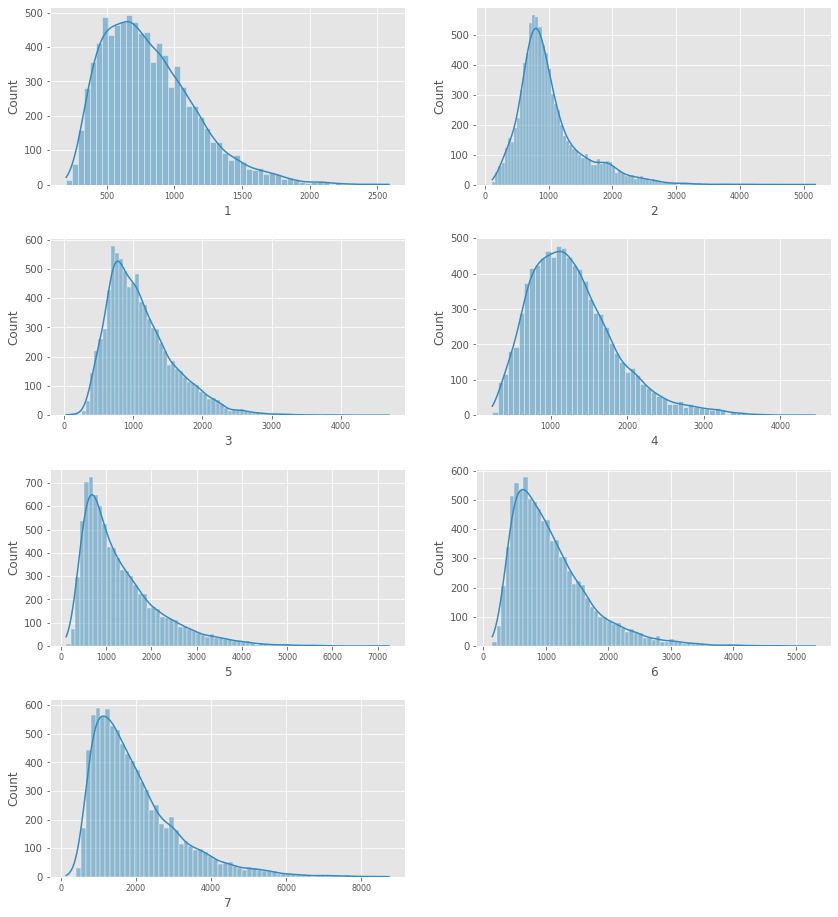

In [10]:
## Histograms: Plotting feature distributions

# Features to plot
columns = data_cluster.columns

# Creating subplot axes
fig, axes = plt.subplots(4, 2, figsize=(14,16), sharey=False)
axes[3,1].set_axis_off()

# Iterating through axes and columns
for col, ax in zip(columns, axes.flatten()):
    sns.histplot(x=col, kde=True, data=data_cluster, ax=ax)
    ax.tick_params(axis='x', labelsize=8)
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    plt.subplots_adjust(hspace=0.3);

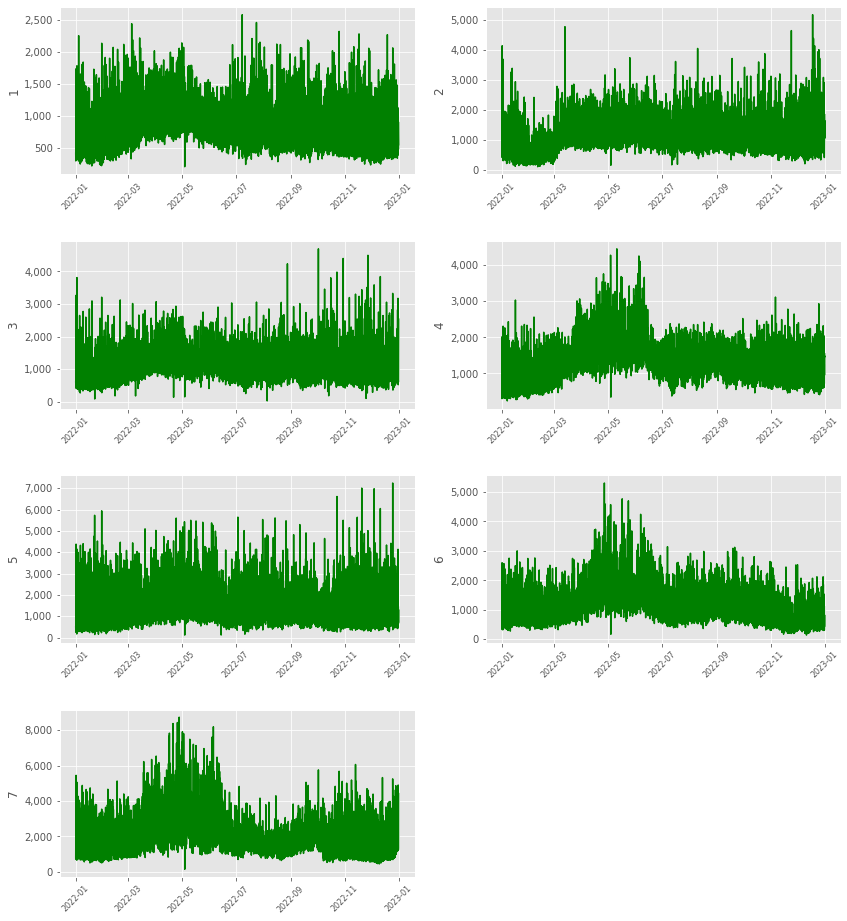

In [11]:
## Plotting features over time

# Features to plot
columns = data_cluster.columns

# Creating subplot axes
fig, axes = plt.subplots(4, 2, figsize=(14,16), sharey=False)
axes[3,1].set_axis_off()

# Iterating through axes and columns
for col, ax in zip(columns, axes.flatten()):
    sns.lineplot(data=data_cluster, x=data_cluster.index, y=col, ax=ax, color='green')
    ax.tick_params(axis='x', labelrotation=45, labelsize=8)
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    plt.subplots_adjust(hspace=0.4);

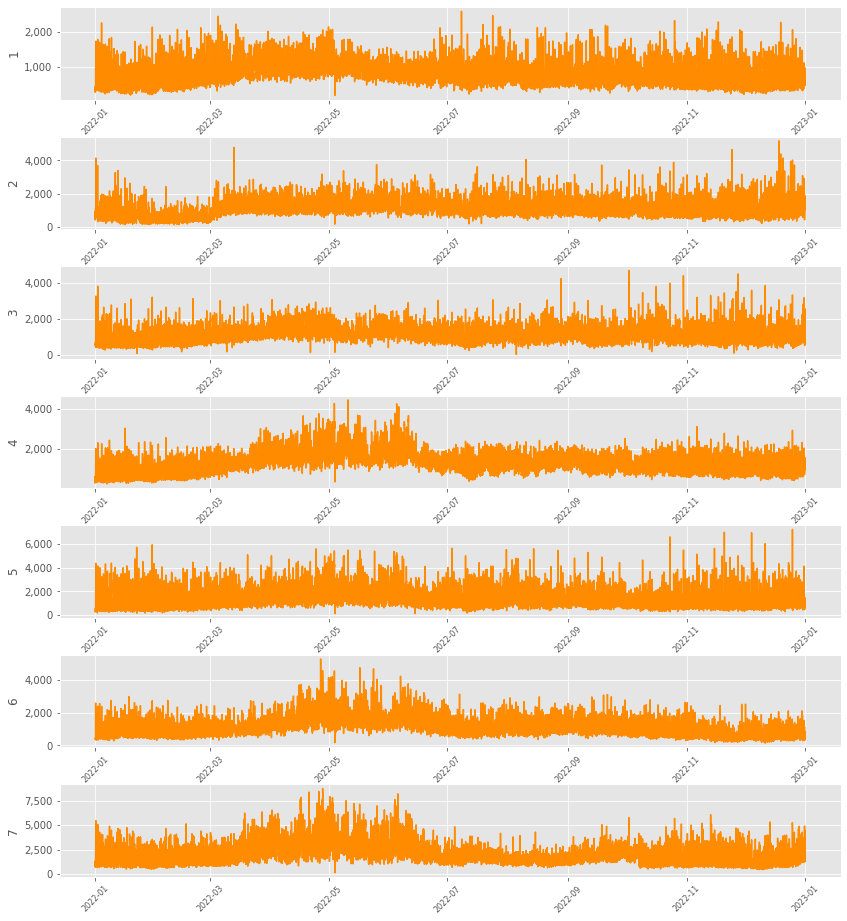

In [12]:
## Plotting features over time (with a different aspect ratio)

# Features to plot
columns = data_cluster.columns

# Creating subplot axes
fig, axes = plt.subplots(7, 1, figsize=(14,16), sharey=False)

# Iterating through axes and columns
for col, ax in zip(columns, axes.flatten()):
    sns.lineplot(data=data_cluster, x=data_cluster.index, y=col, ax=ax, color='darkorange')
    ax.tick_params(axis='x', labelrotation=45, labelsize=8)
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    plt.subplots_adjust(hspace=0.4);

In [13]:
for i in range(1,len(data_cluster.columns)+1):
    print(f'\033[1m Cluster {i} \033[0m')
    results = adfuller(data_cluster.iloc[i]) #results object is a tuple

    # Print Dicky-Fuller test results
    print(f'Dicky-Fuller test results:{results}\n') #0th element: test statistic, 1st element: pval

    # Print test statistic
    print(f'test statistic:{results[0]}\n')

    # Print p-value
    print(f'p-value:{np.round(results[1], 3)}\n')

    # Print critical values
    print(f'critical values:{results[4]}\n') 

    # Significance statement
    alpha = 0.05

    if results[1] < alpha:
        print(f'\033[1mp-value < {alpha}: We reject the null hypothesis\nConclusion: Time series is stationary\033[0m')
    else:
        print(f'\033[1mp-value > {alpha}: We accept the null hypothesis\nConclusion: Time series is not stationary due to trend\033[0m')

 Cluster 1 
Dicky-Fuller test results:(-2.1340189752820224, 0.23105718323109153, 0, 6, {'1%': -5.354256481481482, '5%': -3.6462381481481483, '10%': -2.901197777777778}, 76.26452040451024)

test statistic:-2.1340189752820224

p-value:0.231

critical values:{'1%': -5.354256481481482, '5%': -3.6462381481481483, '10%': -2.901197777777778}

p-value > 0.05: We accept the null hypothesis
Conclusion: Time series is not stationary due to trend
 Cluster 2 
Dicky-Fuller test results:(-1.5351639184397379, 0.5160501268845021, 1, 5, {'1%': -6.045114, '5%': -3.9292800000000003, '10%': -2.98681}, 74.36676748055848)

test statistic:-1.5351639184397379

p-value:0.516

critical values:{'1%': -6.045114, '5%': -3.9292800000000003, '10%': -2.98681}

p-value > 0.05: We accept the null hypothesis
Conclusion: Time series is not stationary due to trend
 Cluster 3 
Dicky-Fuller test results:(-2.2125621431892246, 0.20171775687704846, 1, 5, {'1%': -6.045114, '5%': -3.9292800000000003, '10%': -2.98681}, 65.94432659

In [14]:
def split_data(data, test_size=0.2, analysis='univariate'):
    """
    Function to split time series data into train and test set
    Parameters:
        test_size: float, default=0.2
        analysis: {'univariate', 'univariate'}, default='univariate'
    """
    if analysis == 'univariate':
        position = int(round(len(data) * (1-test_size)))
        train = np.array(data[:position]).reshape(-1,1)
        test = np.array(data[position:]).reshape(-1,1)
    
    elif analysis == 'multivariate':
        position = int(round(len(data) * (1-test_size)))
        train = data[:position]
        test = data[position:]
        
    else:
        print("Please specify if analysis is univariate or multivariate")
        
    return train, test

In [15]:
def scale(data, train_split):
    """
    Function to scale the entire dataset using the mean and standard deviation of the training data only
    """
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    
    return (data - data_mean) / data_std

In [16]:
def inv_scale(data, scaled_data, train_split):
    """
    Function to inverse scaling of data by using the mean and standard deviation of the training data only
    """
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
       
    return scaled_data * data_std + data_mean

In [17]:
def create_samples_univar(data, n_input, n_output):
    """
    Function to convert time series observations
    into input X and output y 
    """
    X, y = [], []
    
    for i in range(n_input, len(data)): #start, stop
        if i+n_output > len(data):
            break
        X.append(data[i-n_input : i])
        y.append(data[i : i+n_output]) 
        
    return np.array(X), np.array(y)

In [18]:
def create_samples_multivar(data, n_input, n_output, target_index=0):
    """
    Function to convert time series observations
    into input X and output y 
    """
    X, y = [], []
    
    # Move column defined by target_index to first position
    a=[]
    a = data[:, target_index].reshape(-1,1)
    b = np.delete(data, target_index, axis=1)
    data = np.concatenate((a, b), axis=1)
            
    for i in range(n_input, len(data)): #start, stop
        if i+n_output > len(data):
            break
        X.append(data[i-n_input : i, :])
        y.append(data[i : i+n_output, 0]) 
        
    return np.array(X), np.array(y)

In [19]:
def summarize_scores(name, score, scores):
    """
    Function to summarize scores
    """
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

In [20]:
def plot_model(history):
    """
    Function to plot training and validation loss
    """
    plt.figure(figsize=(10,5))
    plt.plot(history.history["loss"], color="r", label="Training Loss")
    plt.plot(history.history["val_loss"], color="b", label="Validation Loss")
    plt.legend(loc="upper right")
    plt.xlabel("Epoch", fontsize=16)
    plt.ylabel("Loss", fontsize=16)
    plt.ylim([0, max(plt.ylim())])
    plt.title("Training and Validation Loss", fontsize=16);

In [22]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 1, 2, 64)          37120     
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 24)                3096      
                                                                 
Total params: 40216 (157.09 KB)
Trainable params: 40216 (157.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
408/408 [==============================] - 3s 4ms/step - loss: 0.6084 - mae: 0.5826 - val_loss: 0.5438 - val_mae: 0.5366
Epoch 2/10
408/408 [==============================] - 1s 3ms/step - loss: 0.4965 - mae: 0.5188 - val_loss: 0.5284 - val_mae: 0.5280
Epoch 3/10
40

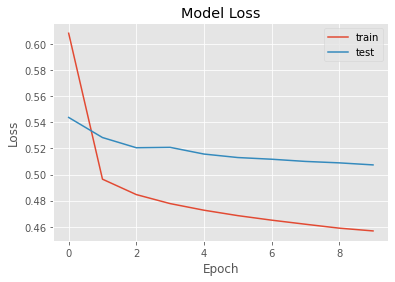

Test Loss: 0.5074
Test MAE: 0.5172

Overall Metrics:
RMSE: 239.580
MAE: 173.948
MAPE: 26.84%
sMAPE: 24.00%
R-Squared: 0.473


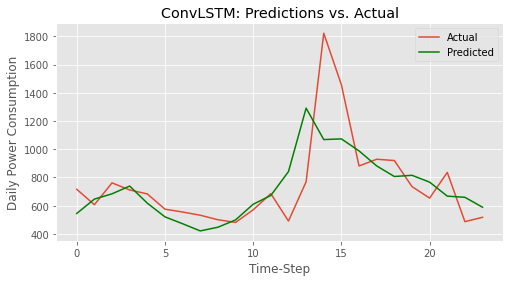

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 1, 2, 64)          37120     
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 24)                3096      
                                                                 
Total params: 40216 (157.09 KB)
Trainable params: 40216 (157.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
408/408 [==============================] - 3s 3ms/step - loss: 0.7461 - mae: 0.6259 - val_loss: 0.8814 - val_mae: 0.6388
Epoch 2/10
408/408 [==============================] - 1s 2ms/step - loss: 0.6800 - mae: 0.5933 - val_loss: 0.8500 - val_mae: 0.6270
Epoch 3/10
40

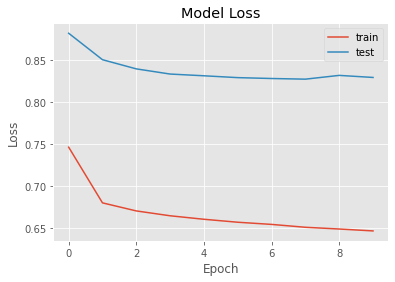

Test Loss: 0.8289
Test MAE: 0.5990

Overall Metrics:
RMSE: 463.387
MAE: 304.859
MAPE: 32.57%
sMAPE: 29.28%
R-Squared: 0.239


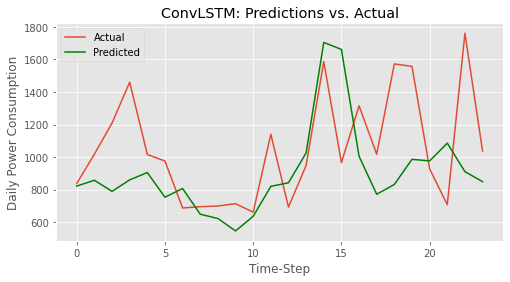

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 1, 2, 64)          37120     
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 24)                3096      
                                                                 
Total params: 40216 (157.09 KB)
Trainable params: 40216 (157.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
408/408 [==============================] - 3s 4ms/step - loss: 0.6154 - mae: 0.5830 - val_loss: 0.8489 - val_mae: 0.6378
Epoch 2/10
408/408 [==============================] - 2s 4ms/step - loss: 0.5088 - mae: 0.5199 - val_loss: 0.8242 - val_mae: 0.6269
Epoch 3/10
40

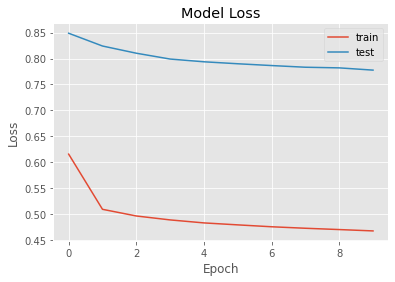

Test Loss: 0.7776
Test MAE: 0.6096

Overall Metrics:
RMSE: 416.785
MAE: 288.114
MAPE: 28.93%
sMAPE: 25.54%
R-Squared: 0.377


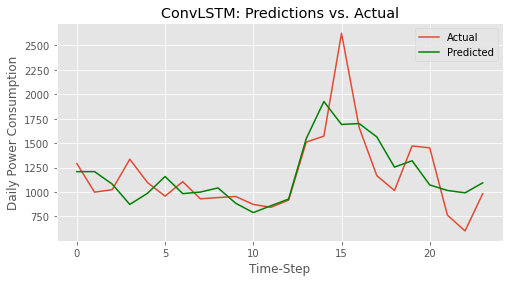

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 1, 2, 64)          37120     
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 24)                3096      
                                                                 
Total params: 40216 (157.09 KB)
Trainable params: 40216 (157.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
408/408 [==============================] - 3s 3ms/step - loss: 0.4276 - mae: 0.4837 - val_loss: 0.2010 - val_mae: 0.3434
Epoch 2/10
408/408 [==============================] - 2s 4ms/step - loss: 0.2890 - mae: 0.4014 - val_loss: 0.1926 - val_mae: 0.3300
Epoch 3/10
40

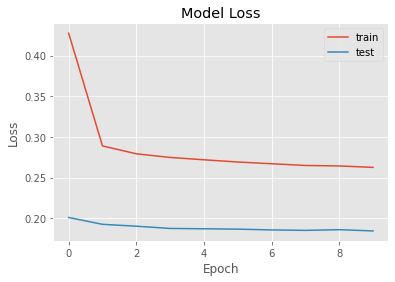

Test Loss: 0.1845
Test MAE: 0.3179

Overall Metrics:
RMSE: 256.026
MAE: 189.524
MAPE: 18.04%
sMAPE: 17.17%
R-Squared: 0.609


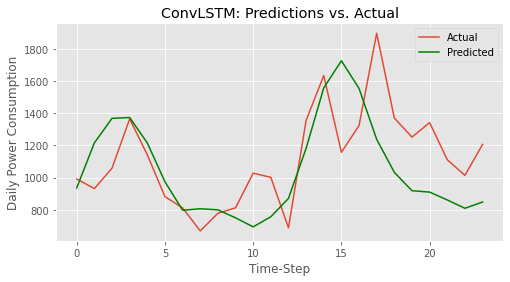

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 1, 2, 64)          37120     
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 24)                3096      
                                                                 
Total params: 40216 (157.09 KB)
Trainable params: 40216 (157.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
408/408 [==============================] - 4s 5ms/step - loss: 0.7505 - mae: 0.6407 - val_loss: 0.5844 - val_mae: 0.5141
Epoch 2/10
408/408 [==============================] - 2s 5ms/step - loss: 0.6572 - mae: 0.5890 - val_loss: 0.5784 - val_mae: 0.5134
Epoch 3/10
40

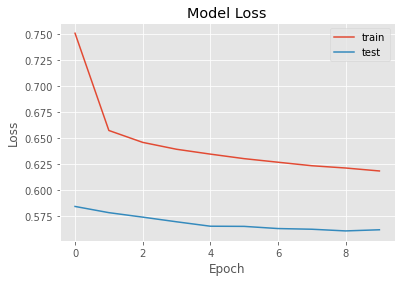

Test Loss: 0.5620
Test MAE: 0.5025

Overall Metrics:
RMSE: 658.649
MAE: 441.477
MAPE: 48.79%
sMAPE: 37.46%
R-Squared: 0.319


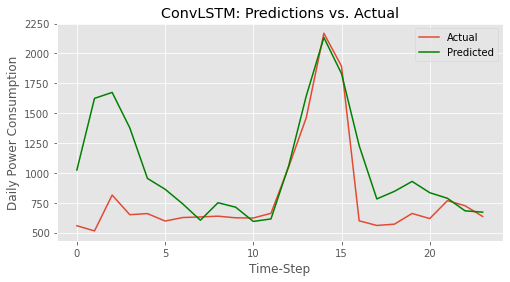

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 1, 2, 64)          37120     
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 24)                3096      
                                                                 
Total params: 40216 (157.09 KB)
Trainable params: 40216 (157.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
408/408 [==============================] - 3s 3ms/step - loss: 0.5623 - mae: 0.5455 - val_loss: 0.2860 - val_mae: 0.3924
Epoch 2/10
408/408 [==============================] - 2s 4ms/step - loss: 0.4383 - mae: 0.4788 - val_loss: 0.2683 - val_mae: 0.3831
Epoch 3/10
40

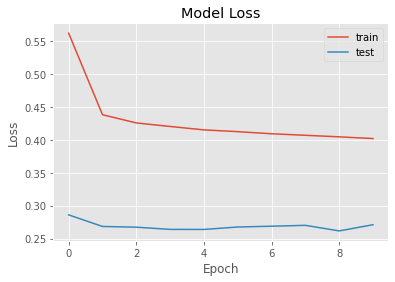

Test Loss: 0.2710
Test MAE: 0.4002

Overall Metrics:
RMSE: 327.786
MAE: 251.993
MAPE: 44.06%
sMAPE: 34.17%
R-Squared: 0.312


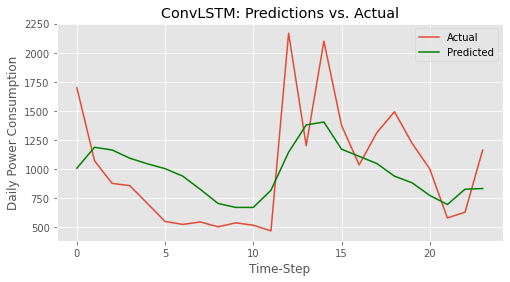

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 1, 2, 64)          37120     
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 24)                3096      
                                                                 
Total params: 40216 (157.09 KB)
Trainable params: 40216 (157.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
408/408 [==============================] - 4s 4ms/step - loss: 0.5671 - mae: 0.5426 - val_loss: 0.3182 - val_mae: 0.4133
Epoch 2/10
408/408 [==============================] - 1s 3ms/step - loss: 0.4483 - mae: 0.4723 - val_loss: 0.3058 - val_mae: 0.4009
Epoch 3/10
40

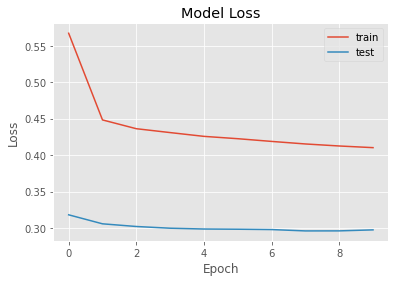

Test Loss: 0.2975
Test MAE: 0.3967

Overall Metrics:
RMSE: 652.098
MAE: 474.183
MAPE: 34.69%
sMAPE: 29.82%
R-Squared: 0.443


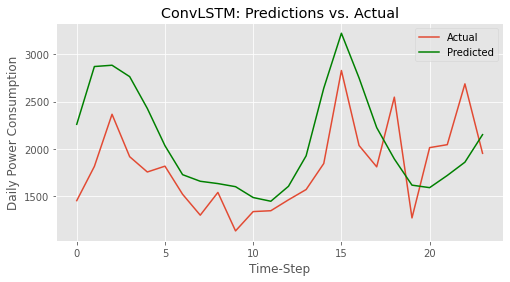

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import ConvLSTM2D, Flatten, Dense
from keras.backend import clear_session
import matplotlib.pyplot as plt


# Scale data (using training data)
def scale(data, train_split):
    train_data = data[:train_split]
    mean = train_data.mean()
    std = train_data.std()
    return (data - mean) / std


# Inverse scaling
def inv_scale(original_data, scaled_data, train_split):
    train_data = original_data[:train_split]
    mean = train_data.mean()
    std = train_data.std()
    return scaled_data * std + mean


# Split data into train/test
def split_data(data, test_size, analysis):
    train_size = int(len(data) * (1 - test_size))
    train, test = data[:train_size], data[train_size:]
    return train, test


# Create samples for univariate time series
def create_samples_univar(data, n_input, n_output):
    X, y = [], []
    for i in range(len(data) - n_input - n_output):
        X.append(data[i:i + n_input])
        y.append(data[i + n_input:i + n_input + n_output])
    return np.array(X), np.array(y)


# Plot model loss and metrics
def plot_model(history):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()


# Data preparation
for i in range(1, len(data_cluster.columns) + 1):
    feature = data_cluster.T.iloc[i - 1]
    test_size = 0.25
    TRAIN_SPLIT = int(round(len(feature) * (1 - test_size)))
    
    # Scale data
    univar_data_scaled = scale(feature.values, TRAIN_SPLIT)
    
    # Split data
    train, test = split_data(data=univar_data_scaled, test_size=test_size, analysis='univariate')
    
    # Create samples
    n_input = 24  # past 24 hours
    n_output = 24  # future 24 hours
    n_steps = 3    # Temporal dimension for ConvLSTM2D
    n_seq = 1      # Number of sequences for ConvLSTM2D
    
    X_train, y_train = create_samples_univar(train, n_input=n_input, n_output=n_output)
    X_test, y_test = create_samples_univar(test, n_input=n_input, n_output=n_output)
    
    # Reshape data to 5D for ConvLSTM2D [samples, timesteps, rows, columns, features]
    X_train = X_train.reshape((X_train.shape[0], n_seq, 1, n_steps, int(n_input / n_steps)))
    X_test = X_test.reshape((X_test.shape[0], n_seq, 1, n_steps, int(n_input / n_steps)))
    y_train = y_train.reshape(y_train.shape[0], n_output, 1)
    y_test = y_test.reshape(y_test.shape[0], n_output, 1)

    # Clear previous session
    clear_session()

    # Create model
    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(1, 2), activation='relu',
                         input_shape=(n_seq, 1, n_steps, int(n_input / n_steps))))
    model.add(Flatten())
    model.add(Dense(n_output))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    print(model.summary())

    # Fit model
    epochs = 10
    batch_size = 16
    history = model.fit(X_train, y_train, epochs=epochs, verbose=1, batch_size=batch_size, validation_data=(X_test, y_test))

    # Plot training history
    plot_model(history)

    # Evaluate model
    score = model.evaluate(X_test, y_test, verbose=0)
    print(f'Test Loss: {score[0]:.4f}')
    print(f'Test MAE: {score[1]:.4f}')

    # Make predictions
    yhat = model.predict(X_test, verbose=0)

    # Inverse scale predictions
    yhat_inv = inv_scale(feature.values, yhat.flatten(), TRAIN_SPLIT)
    y_test_inv = inv_scale(feature.values, y_test.flatten(), TRAIN_SPLIT)

    # Flatten actual and predicted arrays
    actual_flat = y_test_inv
    predicted_flat = yhat_inv

    # Metrics calculation
    rmse_total = mean_squared_error(actual_flat, predicted_flat, squared=False)
    mae_total = mean_absolute_error(actual_flat, predicted_flat)
    mape_total = np.mean(np.abs((actual_flat - predicted_flat) / actual_flat)) * 100
    smape_total = 100 * np.mean(2 * np.abs(actual_flat - predicted_flat) / (np.abs(actual_flat) + np.abs(predicted_flat)))
    r_squared_total = r2_score(actual_flat, predicted_flat)

    # Print metrics
    print("\nOverall Metrics:")
    print(f"RMSE: {rmse_total:.3f}")
    print(f"MAE: {mae_total:.3f}")
    print(f"MAPE: {mape_total:.2f}%")
    print(f"sMAPE: {smape_total:.2f}%")
    print(f"R-Squared: {r_squared_total:.3f}")

    # Plot predictions
    plt.figure(figsize=(8, 4))
    plt.plot(actual_flat[:n_output], label='Actual')
    plt.plot(predicted_flat[:n_output], label='Predicted', color='green')
    plt.xlabel('Time-Step')
    plt.ylabel('Daily Power Consumption')
    plt.title('ConvLSTM: Predictions vs. Actual')
    plt.legend()
    plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 1, 1, 2, 64)       37120     
                                                                 
 batch_normalization (Batch  (None, 1, 1, 2, 64)       256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 1, 1, 2, 64)       0         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 1, 1, 64)          65792     
                                                                 
 batch_normalization_1 (Bat  (None, 1, 1, 64)          256       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 1, 1, 64)          0

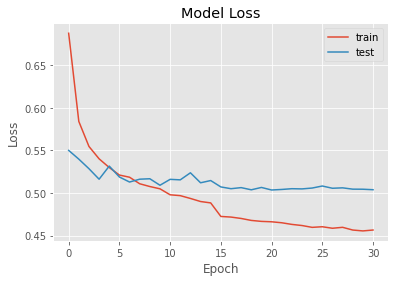

Test Loss: 0.5034
Test MAE: 0.5216

Overall Metrics:
RMSE: 238.632
MAE: 175.437
MAPE: 27.45%
sMAPE: 24.18%
R-Squared: 0.477


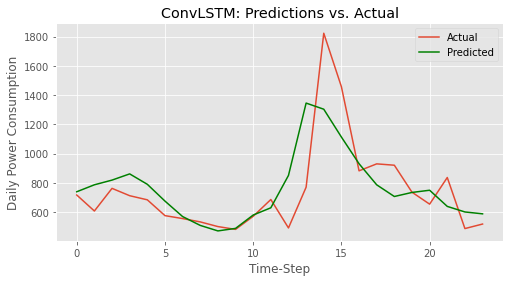

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 1, 1, 2, 64)       37120     
                                                                 
 batch_normalization (Batch  (None, 1, 1, 2, 64)       256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 1, 1, 2, 64)       0         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 1, 1, 64)          65792     
                                                                 
 batch_normalization_1 (Bat  (None, 1, 1, 64)          256       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 1, 1, 64)          0

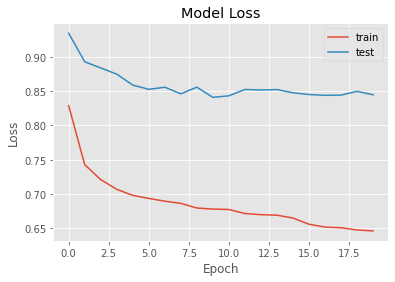

Test Loss: 0.8408
Test MAE: 0.6157

Overall Metrics:
RMSE: 466.710
MAE: 313.359
MAPE: 34.68%
sMAPE: 30.42%
R-Squared: 0.228


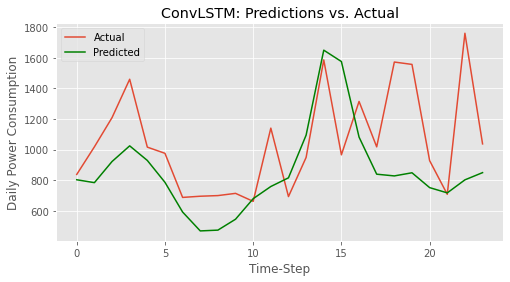

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 1, 1, 2, 64)       37120     
                                                                 
 batch_normalization (Batch  (None, 1, 1, 2, 64)       256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 1, 1, 2, 64)       0         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 1, 1, 64)          65792     
                                                                 
 batch_normalization_1 (Bat  (None, 1, 1, 64)          256       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 1, 1, 64)          0

816/816 [==============================] - 5s 6ms/step - loss: 0.4636 - mae: 0.5012 - val_loss: 0.7868 - val_mae: 0.6117 - lr: 1.0000e-05
Epoch 45/50
816/816 [==============================] - 5s 6ms/step - loss: 0.4624 - mae: 0.5012 - val_loss: 0.7863 - val_mae: 0.6115 - lr: 1.0000e-05
Epoch 46/50
816/816 [==============================] - 5s 6ms/step - loss: 0.4643 - mae: 0.5015 - val_loss: 0.7866 - val_mae: 0.6127 - lr: 1.0000e-05
Epoch 47/50
816/816 [==============================] - 5s 6ms/step - loss: 0.4642 - mae: 0.5017 - val_loss: 0.7872 - val_mae: 0.6120 - lr: 1.0000e-05
Epoch 48/50
816/816 [==============================] - 5s 6ms/step - loss: 0.4632 - mae: 0.5015 - val_loss: 0.7866 - val_mae: 0.6115 - lr: 1.0000e-05
Epoch 49/50
816/816 [==============================] - 6s 7ms/step - loss: 0.4622 - mae: 0.5008 - val_loss: 0.7867 - val_mae: 0.6119 - lr: 1.0000e-05


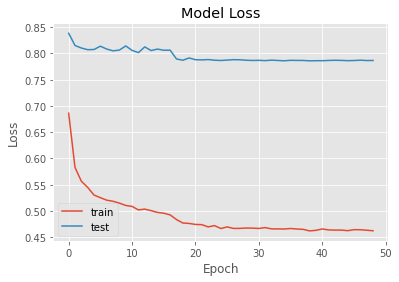

Test Loss: 0.7860
Test MAE: 0.6118

Overall Metrics:
RMSE: 419.018
MAE: 289.155
MAPE: 28.19%
sMAPE: 25.82%
R-Squared: 0.370


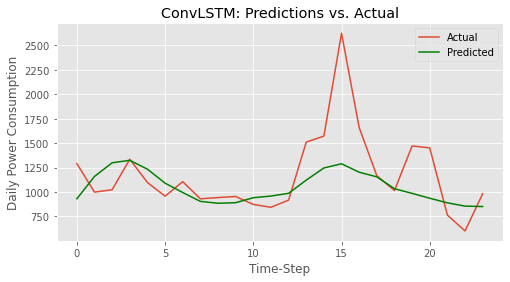

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 1, 1, 2, 64)       37120     
                                                                 
 batch_normalization (Batch  (None, 1, 1, 2, 64)       256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 1, 1, 2, 64)       0         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 1, 1, 64)          65792     
                                                                 
 batch_normalization_1 (Bat  (None, 1, 1, 64)          256       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 1, 1, 64)          0

816/816 [==============================] - 5s 6ms/step - loss: 0.2644 - mae: 0.3896 - val_loss: 0.1822 - val_mae: 0.3182 - lr: 1.0000e-05
Epoch 45/50
816/816 [==============================] - 5s 6ms/step - loss: 0.2657 - mae: 0.3899 - val_loss: 0.1826 - val_mae: 0.3192 - lr: 1.0000e-05
Epoch 46/50
816/816 [==============================] - 4s 5ms/step - loss: 0.2647 - mae: 0.3892 - val_loss: 0.1831 - val_mae: 0.3195 - lr: 1.0000e-05
Epoch 47/50
816/816 [==============================] - 4s 6ms/step - loss: 0.2653 - mae: 0.3895 - val_loss: 0.1833 - val_mae: 0.3210 - lr: 1.0000e-05
Epoch 48/50
816/816 [==============================] - 5s 6ms/step - loss: 0.2651 - mae: 0.3891 - val_loss: 0.1823 - val_mae: 0.3185 - lr: 1.0000e-05


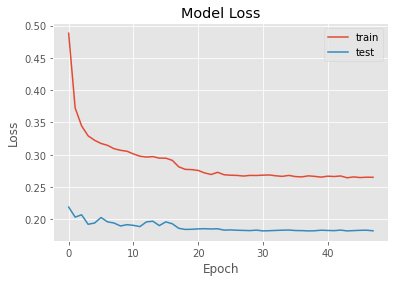

Test Loss: 0.1822
Test MAE: 0.3180

Overall Metrics:
RMSE: 254.433
MAE: 189.546
MAPE: 18.27%
sMAPE: 17.14%
R-Squared: 0.614


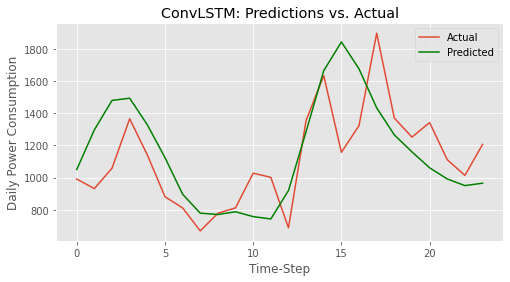

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 1, 1, 2, 64)       37120     
                                                                 
 batch_normalization (Batch  (None, 1, 1, 2, 64)       256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 1, 1, 2, 64)       0         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 1, 1, 64)          65792     
                                                                 
 batch_normalization_1 (Bat  (None, 1, 1, 64)          256       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 1, 1, 64)          0

816/816 [==============================] - 5s 6ms/step - loss: 0.5928 - mae: 0.5598 - val_loss: 0.5631 - val_mae: 0.4974 - lr: 1.0000e-05
Epoch 45/50
816/816 [==============================] - 5s 6ms/step - loss: 0.5932 - mae: 0.5599 - val_loss: 0.5633 - val_mae: 0.4976 - lr: 1.0000e-05
Epoch 46/50
816/816 [==============================] - 5s 6ms/step - loss: 0.5932 - mae: 0.5597 - val_loss: 0.5637 - val_mae: 0.4990 - lr: 1.0000e-05
Epoch 47/50
816/816 [==============================] - 5s 6ms/step - loss: 0.5922 - mae: 0.5592 - val_loss: 0.5641 - val_mae: 0.4979 - lr: 1.0000e-05
Epoch 48/50
816/816 [==============================] - 5s 6ms/step - loss: 0.5937 - mae: 0.5592 - val_loss: 0.5638 - val_mae: 0.4980 - lr: 1.0000e-05
Epoch 49/50
816/816 [==============================] - 5s 6ms/step - loss: 0.5928 - mae: 0.5590 - val_loss: 0.5633 - val_mae: 0.4977 - lr: 1.0000e-05
Epoch 50/50
816/816 [==============================] - 5s 6ms/step - loss: 0.5953 - mae: 0.5599 - val_loss: 0.56

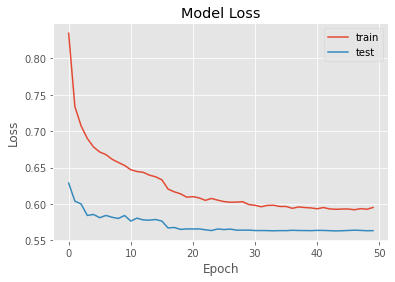

Test Loss: 0.5635
Test MAE: 0.4974

Overall Metrics:
RMSE: 659.528
MAE: 437.037
MAPE: 48.75%
sMAPE: 36.43%
R-Squared: 0.318


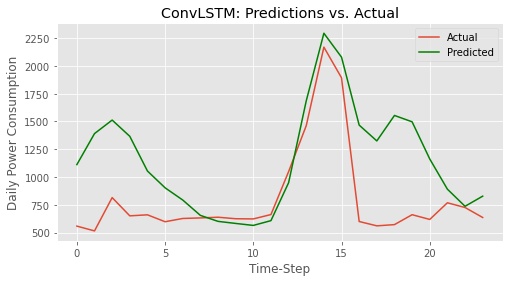

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 1, 1, 2, 64)       37120     
                                                                 
 batch_normalization (Batch  (None, 1, 1, 2, 64)       256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 1, 1, 2, 64)       0         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 1, 1, 64)          65792     
                                                                 
 batch_normalization_1 (Bat  (None, 1, 1, 64)          256       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 1, 1, 64)          0

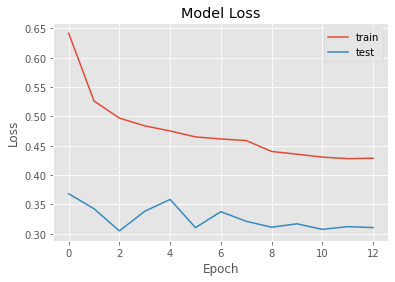

Test Loss: 0.3049
Test MAE: 0.4310

Overall Metrics:
RMSE: 347.675
MAE: 271.377
MAPE: 48.01%
sMAPE: 36.67%
R-Squared: 0.226


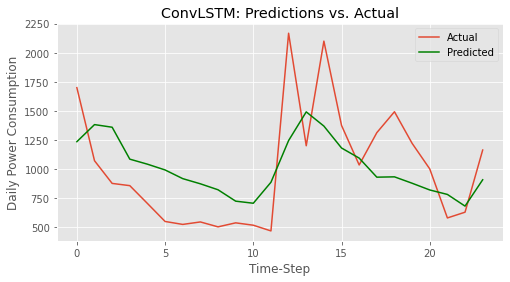

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 1, 1, 2, 64)       37120     
                                                                 
 batch_normalization (Batch  (None, 1, 1, 2, 64)       256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 1, 1, 2, 64)       0         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 1, 1, 64)          65792     
                                                                 
 batch_normalization_1 (Bat  (None, 1, 1, 64)          256       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 1, 1, 64)          0

816/816 [==============================] - 4s 5ms/step - loss: 0.3826 - mae: 0.4478 - val_loss: 0.2905 - val_mae: 0.3973 - lr: 4.0000e-05
Epoch 45/50
816/816 [==============================] - 4s 5ms/step - loss: 0.3829 - mae: 0.4474 - val_loss: 0.2902 - val_mae: 0.3967 - lr: 4.0000e-05
Epoch 46/50
816/816 [==============================] - 4s 5ms/step - loss: 0.3820 - mae: 0.4473 - val_loss: 0.2903 - val_mae: 0.3963 - lr: 4.0000e-05
Epoch 47/50
816/816 [==============================] - 4s 5ms/step - loss: 0.3820 - mae: 0.4480 - val_loss: 0.2892 - val_mae: 0.3937 - lr: 4.0000e-05
Epoch 48/50
816/816 [==============================] - 4s 5ms/step - loss: 0.3815 - mae: 0.4465 - val_loss: 0.2890 - val_mae: 0.3945 - lr: 4.0000e-05
Epoch 49/50
816/816 [==============================] - 5s 6ms/step - loss: 0.3815 - mae: 0.4470 - val_loss: 0.2890 - val_mae: 0.3939 - lr: 4.0000e-05
Epoch 50/50
816/816 [==============================] - 5s 6ms/step - loss: 0.3795 - mae: 0.4462 - val_loss: 0.29

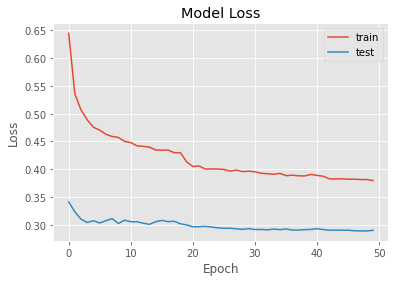

Test Loss: 0.2901
Test MAE: 0.3962

Overall Metrics:
RMSE: 643.901
MAE: 473.680
MAPE: 35.50%
sMAPE: 30.15%
R-Squared: 0.457


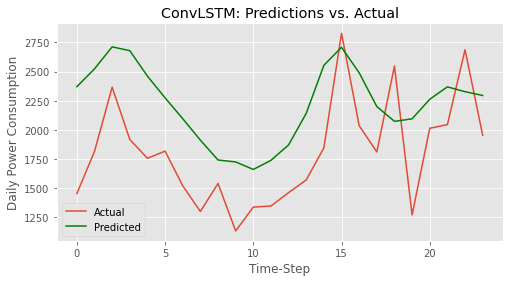

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import ConvLSTM2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.backend import clear_session
import matplotlib.pyplot as plt


# Data preparation, scaling, and splitting functions remain the same...

for i in range(1, len(data_cluster.columns) + 1):
    feature = data_cluster.T.iloc[i - 1]
    test_size = 0.25
    TRAIN_SPLIT = int(round(len(feature) * (1 - test_size)))
    
    # Scale data
    univar_data_scaled = scale(feature.values, TRAIN_SPLIT)
    
    # Split data
    train, test = split_data(data=univar_data_scaled, test_size=test_size, analysis='univariate')
    
    # Create samples
    n_input = 24  # past 24 hours
    n_output = 24  # future 24 hours
    n_steps = 3    # Temporal dimension for ConvLSTM2D
    n_seq = 1      # Number of sequences for ConvLSTM2D
    
    X_train, y_train = create_samples_univar(train, n_input=n_input, n_output=n_output)
    X_test, y_test = create_samples_univar(test, n_input=n_input, n_output=n_output)
    
    # Reshape data to 5D for ConvLSTM2D (batch_size, time_steps, rows, columns, channels)
    X_train = X_train.reshape((X_train.shape[0], n_seq, 1, n_steps, int(n_input / n_steps)))
    X_test = X_test.reshape((X_test.shape[0], n_seq, 1, n_steps, int(n_input / n_steps)))
    
    # Reshape target variable to match the ConvLSTM2D output
    y_train = y_train.reshape(y_train.shape[0], n_output, 1)
    y_test = y_test.reshape(y_test.shape[0], n_output, 1)

    # Clear previous session
    clear_session()

    # Create the ConvLSTM2D model
    model = Sequential()
    
    # First ConvLSTM2D layer (with return_sequences=True for stacking)
    model.add(ConvLSTM2D(filters=64, kernel_size=(1, 2), activation='relu',
                         input_shape=(n_seq, 1, n_steps, int(n_input / n_steps)), return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # Second ConvLSTM2D layer (without return_sequences)
    model.add(ConvLSTM2D(filters=64, kernel_size=(1, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # Flatten the output from 5D to 2D
    model.add(Flatten())

    # Dense layers for output
    model.add(Dense(128, activation='relu'))
    model.add(Dense(n_output))  # Output layer for n_output time steps

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    print(model.summary())

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

    # Fit model
    epochs = 50  # Increase epochs
    batch_size = 8  # Reduce batch size

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        verbose=1,
        callbacks=[early_stopping, reduce_lr]
    )

    # Plot training history
    plot_model(history)

    # Evaluate model
    score = model.evaluate(X_test, y_test, verbose=0)
    print(f'Test Loss: {score[0]:.4f}')
    print(f'Test MAE: {score[1]:.4f}')

    # Make predictions
    yhat = model.predict(X_test, verbose=0)

    # Inverse scale predictions
    yhat_inv = inv_scale(feature.values, yhat.flatten(), TRAIN_SPLIT)
    y_test_inv = inv_scale(feature.values, y_test.flatten(), TRAIN_SPLIT)

    # Flatten actual and predicted arrays
    actual_flat = y_test_inv
    predicted_flat = yhat_inv

    # Metrics calculation
    rmse_total = mean_squared_error(actual_flat, predicted_flat, squared=False)
    mae_total = mean_absolute_error(actual_flat, predicted_flat)
    mape_total = np.mean(np.abs((actual_flat - predicted_flat) / actual_flat)) * 100
    smape_total = 100 * np.mean(2 * np.abs(actual_flat - predicted_flat) / (np.abs(actual_flat) + np.abs(predicted_flat)))
    r_squared_total = r2_score(actual_flat, predicted_flat)

    # Print metrics
    print("\nOverall Metrics:")
    print(f"RMSE: {rmse_total:.3f}")
    print(f"MAE: {mae_total:.3f}")
    print(f"MAPE: {mape_total:.2f}%")
    print(f"sMAPE: {smape_total:.2f}%")
    print(f"R-Squared: {r_squared_total:.3f}")

    # Plot predictions
    plt.figure(figsize=(8, 4))
    plt.plot(actual_flat[:n_output], label='Actual')
    plt.plot(predicted_flat[:n_output], label='Predicted', color='green')
    plt.xlabel('Time-Step')
    plt.ylabel('Daily Power Consumption')
    plt.title('ConvLSTM: Predictions vs. Actual')
    plt.legend()
    plt.show()


# CNN LSTM (Conv1D)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 22, 64)            256       
                                                                 
 max_pooling1d (MaxPooling1  (None, 11, 64)            0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 50)                23000     
                                                                 
 dense (Dense)               (None, 24)                1224      
                                                                 
Total params: 24480 (95.62 KB)
Trainable params: 24480 (95.62 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
408/408 [==============================] - 3s 5ms/step - loss: 0.0188 

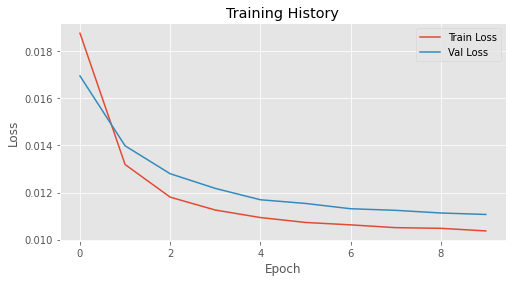

67/67 [==============================] - 0s 2ms/step

Overall Metrics:
RMSE: 250.815
MAE: 183.393
MAPE: 28.37%
sMAPE: 25.31%
R-Squared: 0.422


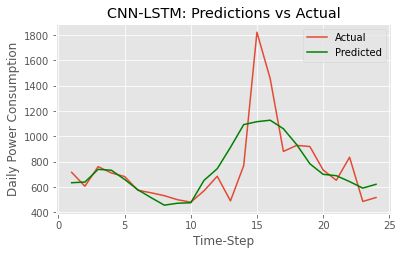

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 22, 64)            256       
                                                                 
 max_pooling1d (MaxPooling1  (None, 11, 64)            0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 50)                23000     
                                                                 
 dense (Dense)               (None, 24)                1224      
                                                                 
Total params: 24480 (95.62 KB)
Trainable params: 24480 (95.62 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
408/408 [==============================] - 3s 4ms/step - loss: 0.0110 

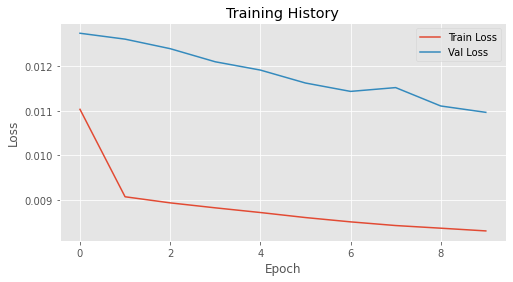

67/67 [==============================] - 0s 2ms/step

Overall Metrics:
RMSE: 488.331
MAE: 327.505
MAPE: 35.84%
sMAPE: 31.43%
R-Squared: 0.155


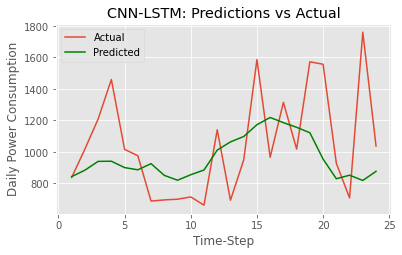

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 22, 64)            256       
                                                                 
 max_pooling1d (MaxPooling1  (None, 11, 64)            0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 50)                23000     
                                                                 
 dense (Dense)               (None, 24)                1224      
                                                                 
Total params: 24480 (95.62 KB)
Trainable params: 24480 (95.62 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
408/408 [==============================] - 3s 5ms/step - loss: 0.0132 

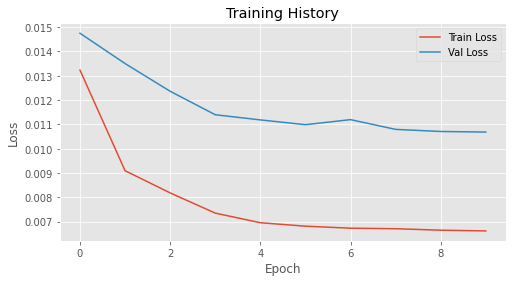

67/67 [==============================] - 0s 2ms/step

Overall Metrics:
RMSE: 434.517
MAE: 300.582
MAPE: 29.59%
sMAPE: 26.98%
R-Squared: 0.323


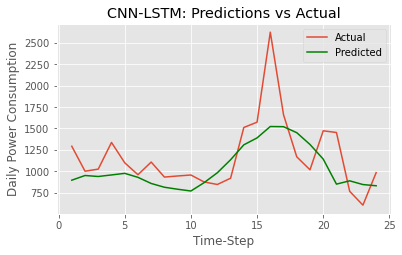

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 22, 64)            256       
                                                                 
 max_pooling1d (MaxPooling1  (None, 11, 64)            0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 50)                23000     
                                                                 
 dense (Dense)               (None, 24)                1224      
                                                                 
Total params: 24480 (95.62 KB)
Trainable params: 24480 (95.62 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
408/408 [==============================] - 3s 5ms/step - loss: 0.0147 

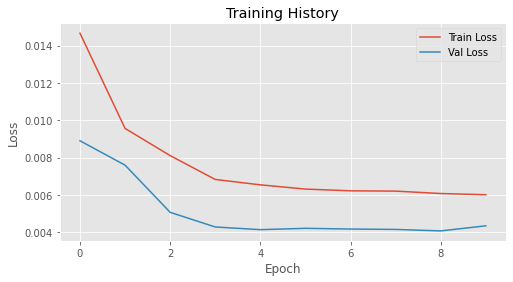

67/67 [==============================] - 0s 2ms/step

Overall Metrics:
RMSE: 277.950
MAE: 214.118
MAPE: 21.51%
sMAPE: 19.53%
R-Squared: 0.539


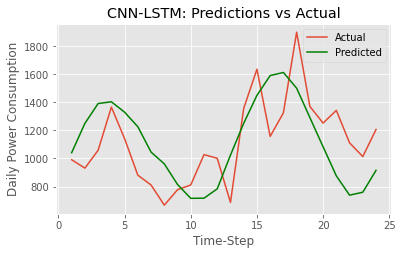

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 22, 64)            256       
                                                                 
 max_pooling1d (MaxPooling1  (None, 11, 64)            0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 50)                23000     
                                                                 
 dense (Dense)               (None, 24)                1224      
                                                                 
Total params: 24480 (95.62 KB)
Trainable params: 24480 (95.62 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
408/408 [==============================] - 3s 5ms/step - loss: 0.0219 

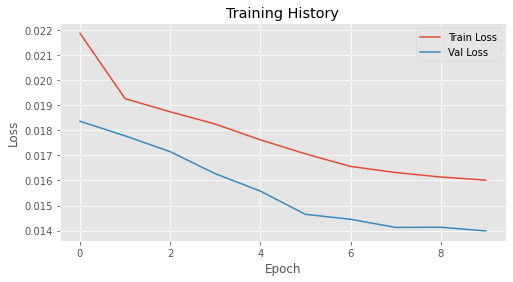

67/67 [==============================] - 0s 2ms/step

Overall Metrics:
RMSE: 688.400
MAE: 470.096
MAPE: 52.69%
sMAPE: 40.04%
R-Squared: 0.256


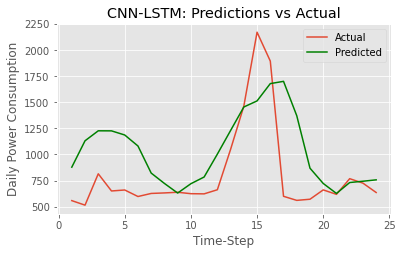

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 22, 64)            256       
                                                                 
 max_pooling1d (MaxPooling1  (None, 11, 64)            0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 50)                23000     
                                                                 
 dense (Dense)               (None, 24)                1224      
                                                                 
Total params: 24480 (95.62 KB)
Trainable params: 24480 (95.62 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
408/408 [==============================] - 3s 5ms/step - loss: 0.0125 

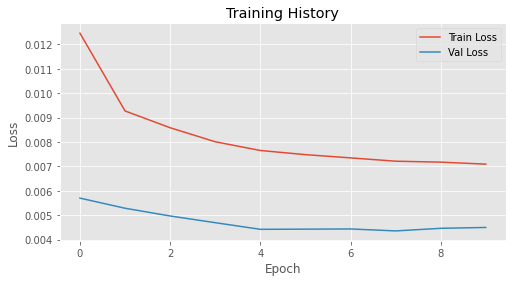

67/67 [==============================] - 0s 2ms/step

Overall Metrics:
RMSE: 344.321
MAE: 265.582
MAPE: 46.47%
sMAPE: 36.16%
R-Squared: 0.241


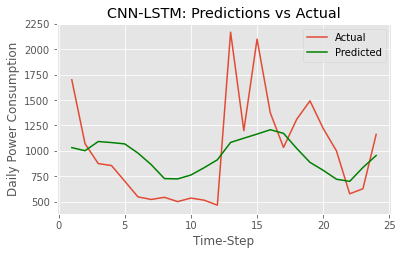

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 22, 64)            256       
                                                                 
 max_pooling1d (MaxPooling1  (None, 11, 64)            0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 50)                23000     
                                                                 
 dense (Dense)               (None, 24)                1224      
                                                                 
Total params: 24480 (95.62 KB)
Trainable params: 24480 (95.62 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
408/408 [==============================] - 3s 4ms/step - loss: 0.0158 

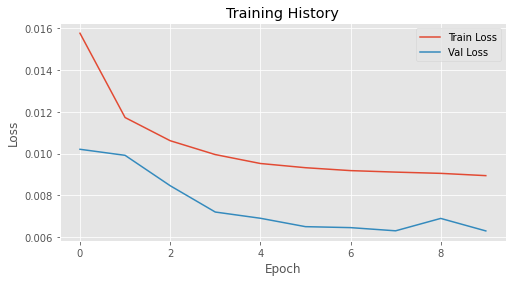

67/67 [==============================] - 0s 2ms/step

Overall Metrics:
RMSE: 681.484
MAE: 508.324
MAPE: 38.51%
sMAPE: 32.08%
R-Squared: 0.391


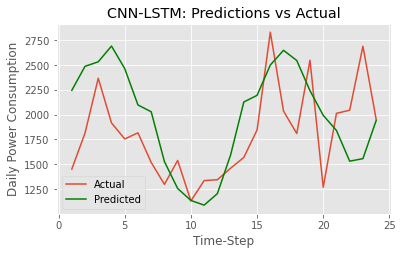

In [35]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Flatten, Dense, TimeDistributed
from keras.optimizers import Adam
from keras.backend import clear_session
import matplotlib.pyplot as plt


# Define function for data scaling
def scale(data, train_split):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data[:train_split].reshape(-1, 1))
    scaled = np.append(scaled, scaler.transform(data[train_split:].reshape(-1, 1)))
    return scaled.reshape(-1, 1), scaler


# Define function for inverse scaling
def inv_scale(scaler, data):
    return scaler.inverse_transform(data)


# Define function to create sequences for the CNN-LSTM model
def create_samples_univar(data, n_input=24, n_output=24):
    X, y = [], []
    for i in range(len(data) - n_input - n_output):
        X.append(data[i:i+n_input])
        y.append(data[i+n_input:i+n_input+n_output])
    return np.array(X), np.array(y)


# Loop over clusters (total daily consumption)
for i in range(1, len(data_cluster.columns) + 1):
    feature = data_cluster.T.iloc[i-1]

    # Train/test split
    test_size = 0.25
    TRAIN_SPLIT = int(round(len(feature) * (1 - test_size)))
    
    # Scale data
    univar_data = feature.values
    univar_data_scaled, scaler = scale(univar_data, TRAIN_SPLIT)
    
    # Split data into train and test
    train, test = univar_data_scaled[:TRAIN_SPLIT], univar_data_scaled[TRAIN_SPLIT:]

    # Create sequences for CNN-LSTM
    n_input = 24  # Past 24 hours
    n_output = 24  # Predict 24 hours
    X_train, y_train = create_samples_univar(train, n_input=n_input, n_output=n_output)
    X_test, y_test = create_samples_univar(test, n_input=n_input, n_output=n_output)
    
    # Reshape input for Conv1D (samples, timesteps, features)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    # Clear previous models
    clear_session()

    # Build CNN-LSTM Model
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_input, 1)),
        MaxPooling1D(pool_size=2),
        LSTM(50, activation='relu'),
        Dense(n_output)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    print(model.summary())

    # Train the model
    history = model.fit(
        X_train, y_train, 
        epochs=10, 
        batch_size=16, 
        validation_data=(X_test, y_test), 
        verbose=1
    )

    # Plot training history
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    # Evaluate the model
    yhat = model.predict(X_test)
    
    # Inverse scaling of prediction
    yhat_inv = inv_scale(scaler, yhat.reshape(-1, 1))
    y_test_inv = inv_scale(scaler, y_test.reshape(-1, 1))

    # Flatten actual and predicted arrays for metrics
    actual_flat = y_test_inv.flatten()
    predicted_flat = yhat_inv.flatten()

    # Calculate overall metrics
    rmse_total = mean_squared_error(actual_flat, predicted_flat, squared=False)
    mae_total = mean_absolute_error(actual_flat, predicted_flat)
    mape_total = np.mean(np.abs((actual_flat - predicted_flat) / actual_flat)) * 100
    smape_total = 100 * np.mean(2 * np.abs(actual_flat - predicted_flat) / (np.abs(actual_flat) + np.abs(predicted_flat)))
    r_squared_total = r2_score(actual_flat, predicted_flat)

    # Print overall metrics
    print("\nOverall Metrics:")
    print(f"RMSE: {rmse_total:.3f}")
    print(f"MAE: {mae_total:.3f}")
    print(f"MAPE: {mape_total:.2f}%")
    print(f"sMAPE: {smape_total:.2f}%")
    print(f"R-Squared: {r_squared_total:.3f}")

    # Plot predictions vs actual
    plt.figure(figsize=(6, 3.5))
    future_seq = np.arange(1, len(y_test[0]) + 1)
    plt.plot(future_seq, actual_flat[:len(future_seq)], label='Actual')
    plt.plot(future_seq, predicted_flat[:len(future_seq)], label='Predicted', color='green')
    plt.xlabel('Time-Step')
    plt.ylabel('Daily Power Consumption')
    plt.title('CNN-LSTM: Predictions vs Actual')
    plt.legend()
    plt.show()


# Input data: clusters (total daily consumption)
for i in range(1,len(data_cluster.columns)+1):
    # Input data: cluster 1 (total daily consumption)
    feature = data_cluster
    print(feature.head())
    # Define train/test split
    test_size = 0.25
    TRAIN_SPLIT = int(round(len(dataset) * (1-test_size)))
    print("TRAIN_SPLIT",TRAIN_SPLIT)
    # Get data values
    univar_data = feature.values
    print("univar_data",univar_data)
    # Scale data (using training data)
    univar_data_scaled = scale(univar_data, TRAIN_SPLIT)
    print(univar_data_scaled.shape, univar_data_scaled)
    # Split data into train and test
    train, test = split_data(data=univar_data_scaled, test_size=test_size, analysis='univariate')

    # Print shape and first 5 values for train set
    print("Shape train:", train.shape, "\nShape test:", test.shape, '\n')
    print(train[:5])
    # Visualize train/test split
    plt.figure(figsize=(12,4))
    plt.plot(dataset.iloc[:len(train), 5])
    plt.plot(dataset.iloc[len(train):, 5])
    plt.xlabel('datetime')
    plt.ylabel("electricity_consumption")
    plt.tick_params(axis='x', labelrotation=45, labelsize=8)
    plt.legend(['train','test']);
    # Create samples for train and test set
    n_input = 48
    n_output = 24

    X_train, y_train = create_samples_univar(train, n_input=n_input, n_output=n_output)
    X_test, y_test = create_samples_univar(test, n_input=n_input, n_output=n_output)

    # Print shape and first 3 values for train set
    print("Shape X_train y_train:", X_train.shape, y_train.shape,
          "\nShape X_test y_test:", X_test.shape, y_test.shape, '\n')
    for i in range(2):
        print(X_train[i], y_train[i])
    #print(train[-5:], test[-5:])
    #print(X_train[-1], y_train[-1])
    #print(X_test[-1], y_test[-1])
    #print(X_train[0], y_train[0])
    #print(X_test[0], y_test[0])

    # Create model
    clear_session()

    n_features = X_train.shape[2]
    n_input = X_train.shape[1]
    n_output = y_train.shape[1]

    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
    model.add(RepeatVector(n_output))
    model.add(LSTM(100, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(50, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(optimizer='adam', loss='mse', metrics='mae')

    print(model.summary())
    
    # Fit model
    epochs = 10
    verbose = 0
    batch_size = 16 #default 32

    history = model.fit(X_train, y_train, epochs=epochs, verbose=verbose,batch_size=batch_size, validation_data=(X_test, y_test))
    plot_model(history)
    
    # Loss and mae value for the model in test mode
    score = model.evaluate(X_test, y_test, verbose = 0)
    print(f'Test loss: {score[0]:.4f}') 
    print(f'Test mae: {score[1]:.4f}')
    # List all data in history
    print(history.history.keys())
    print(history.history["loss"][:5])
    print(history.history["mae"][:5])
    # Reshape data for prediction into [1, n_input, 1]
    x_input = X_test[0].reshape((1, len(X_test[0]), 1))
    print(x_input.shape)
    # Make prediction
    yhat = model.predict(x_input, verbose=0)

    print(yhat.shape)
    print(yhat)

    # Inverse scaling of prediction
    yhat_inv = inv_scale(univar_data, yhat, TRAIN_SPLIT)
    print(yhat_inv.shape)
    print(yhat_inv)

    # Inverse scaling of X_test, y_test
    X_test_inv = inv_scale(univar_data, X_test, TRAIN_SPLIT)
    y_test_inv = inv_scale(univar_data, y_test, TRAIN_SPLIT)

    print(X_test_inv.shape, y_test_inv.shape)
    # Plot prediction
    plt.figure(figsize=(6,3.5))

    past_seq = range(-len(X_test[0])+1, 1)
    future_seq = np.arange(1, len(y_test[0])+1)

    plt.plot(past_seq, X_test_inv[0], color='blue', marker='.', label='History')
    plt.plot(future_seq, y_test_inv[0], marker='x', label='True Future')
    plt.plot(future_seq, yhat_inv.reshape(-1,1), color='green', marker='o', label='Model Prediction')

    plt.xlabel('Time-Step')
    plt.ylabel('Daily Power Consumption (kW)')
    plt.xticks(range(-n_input,n_output,2))
    plt.title('Univariate Encoder-Decoder LSTM model: Multi-step prediction')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10);

    ## Now randomly select 3 more samples from the test set, perform model prediction and plot results 

    for i in random.sample(range(len(X_test)), 3):
        print(f"Randomly selected sample: {i}")

        # Reshape data for prediction into [1, n_input, 1]
        x_input = X_test[i].reshape((1, len(X_test[i]), 1))

        # Make prediction
        pred = model.predict(x_input, verbose=0)

        # Inverse scaling of prediction
        pred_inv = inv_scale(univar_data, pred, TRAIN_SPLIT)

        # Plot prediction
        plt.figure(figsize=(6,3.5))

        past_seq = range(-len(X_test[0])+1, 1)
        future_seq = np.arange(1, len(y_test[0])+1)

        plt.plot(past_seq, X_test_inv[i], color='blue', marker='.', label='History')
        plt.plot(future_seq, y_test_inv[i], marker='x', label='True Future')
        plt.plot(future_seq, pred_inv.reshape(-1,1), color='green', marker='o', label='Model Prediction')

        plt.xlabel('Time-Step')
        plt.ylabel('Daily Power Consumption (kW)')
        plt.xticks(range(-n_input,n_output,2))
        plt.title('Univariate Encoder-Decoder LSTM model: Multi-step prediction')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10);

    # Actual values
    actual = y_test_inv[0]

    # Predicted values
    predicted = yhat_inv.reshape(-1,1)
    print(actual.shape, predicted.shape)
    print("actual:",actual)
    print("predicted",predicted)
    
    # Calculate RMSE score for each day
    rmse_hour = []

    for i in range(actual.shape[0]):
        # calculate rmse
        rmse = mean_squared_error(actual[i], predicted[i], squared=False)
        rmse_hour.append(rmse)

    print(rmse_hour)
    # Store RMSE scores of each day in df
    df_rmse =pd.DataFrame()
    df_rmse['Univariate Encoder-Decoder LSTM'] = rmse_hour
    # Plot RMSE score for each hour
    future_seq = np.arange(1, len(y_test[0])+1)

    plt.figure(figsize=(6,3.5))
    plt.plot(future_seq, rmse_hour, marker='o', color='darkred')
    plt.xlabel('Time-Step')
    plt.ylabel('RMSE (kW)')
    plt.title('Univariate Encoder-Decoder LSTM model: RMSE per hour forecast');

    # Calculate overall RMSE score (for the respective forecast period)
    rmse_total = mean_squared_error(actual, predicted, squared=False)
    print(rmse_total)

    # Store overall RMSE score in dict
    performance_rmse = {}
    performance_rmse.update( {'Univariate Encoder-Decoder LSTM' : rmse_total} )

    # Summarize scores
    summarize_scores('RMSE scores for Univariate Stacked LSTM [total] per hour', rmse_total, rmse_hour)


In [21]:
# univariate convlstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import ConvLSTM2D

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 4
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, rows, columns, features]
n_features = 1
n_seq = 2
n_steps = 2
X = X.reshape((X.shape[0], n_seq, 1, n_steps, n_features))
# define model
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps, n_features)))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=500, verbose=0)
# demonstrate prediction
x_input = array([60, 70, 80, 90])
x_input = x_input.reshape((1, n_seq, 1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[103.59057]]


 Encoder-Decoder LSTM Model
    